Importando libs

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from utils import *

from lightgbm import LGBMClassifier

Carregando datasets

In [8]:
train = pd.read_csv('../data/train.csv')
prod  = pd.read_csv('../data/production.csv')

train.head()

,cgpa,internships,projects,workshops_certifications,aptitude_test_score,soft_skills_rating,extra_curricular_activities,placement_training,ssc_marks,hsc_marks,n_job_applications,personality_type,placement_status,student_id
0,8.40,2,2,0,74,4.40,Yes,No,79,85,4,2,0,4085
1,7.60,1,2,1,75,4.30,Yes,Yes,80,67,7,4,1,2992
2,7.60,1,2,1,61,3.20,No,No,61,57,7,2,0,8623
3,7.50,1,2,0,78,4.40,Yes,Yes,61,71,7,2,0,8811
4,8.45,2,3,2,82,4.89,Yes,Yes,75,93,23,3,1,10072


Separando features de target e removendo id dos estudantes

In [9]:
X = train.drop(['student_id','placement_status'],axis = 1)
y = train['placement_status']

X['total_marks'] = ((10*X['cgpa']) + X['ssc_marks'] + X['hsc_marks'])/3

display(X.head())
display(y.head())

,cgpa,internships,projects,workshops_certifications,aptitude_test_score,soft_skills_rating,extra_curricular_activities,placement_training,ssc_marks,hsc_marks,n_job_applications,personality_type,total_marks
0,8.40,2,2,0,74,4.40,Yes,No,79,85,4,2,82.666667
1,7.60,1,2,1,75,4.30,Yes,Yes,80,67,7,4,74.333333
2,7.60,1,2,1,61,3.20,No,No,61,57,7,2,64.666667
3,7.50,1,2,0,78,4.40,Yes,Yes,61,71,7,2,69.000000
4,8.45,2,3,2,82,4.89,Yes,Yes,75,93,23,3,84.166667


0    0
1    1
2    0
3    0
4    1
Name: placement_status, dtype: int64

Separando em treino e teste

In [10]:
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print(f'train --> features shape: {X_train.shape}, target shape: {y_train.shape}')
print(f'test  --> features shape: {X_test.shape}, target shape: {y_test.shape}')

train --> features shape: (7360, 13), target shape: (7360,)
test  --> features shape: (1840, 13), target shape: (1840,)


Separando variaveis categoricas das numericas

In [11]:
categorical_cols = ['extra_curricular_activities', 'placement_training','personality_type']
numeric_cols = []

for col in X.columns:
    
    if col not in categorical_cols:
        numeric_cols.append(col)


print('Features numericas:', numeric_cols)
print('Features categoricas: ', categorical_cols)

Features numericas: ['cgpa', 'internships', 'projects', 'workshops_certifications', 'aptitude_test_score', 'soft_skills_rating', 'ssc_marks', 'hsc_marks', 'n_job_applications', 'total_marks']
Features categoricas:  ['extra_curricular_activities', 'placement_training', 'personality_type']


Definindo modelos

In [55]:
models = {
    'LogisticRegression': CalibratedClassifierCV(LogisticRegression(class_weight='balanced'), cv = 5, method='isotonic'),
    #'Knn':  CalibratedClassifierCV(KNeighborsClassifier(), cv = 5, method='isotonic'),
    #'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced'),
    'RandomForestClassifier':  RandomForestClassifier(n_estimators=1000,class_weight='balanced',random_state = 0),
}

Definindo pipeline de pré processamento

In [13]:
category_processing = Pipeline(steps=[('encoder',OneHotEncoder())])

numeric_processing = Pipeline(steps=[('scaler',StandardScaler())])


preprocessing = ColumnTransformer([
                                    ('category_preprocessing',category_processing,categorical_cols),
                                    ('numeric_preprocessing',numeric_processing,numeric_cols)],
                                    remainder='passthrough'
                                )



In [56]:
for i, (name, model) in enumerate(models.items()):

    print(f'Métricas para {name}')
    clf = Pipeline(steps=[('preprocessing', preprocessing), ('model', model)])
    print(validacaoCruzada(X_train,y_train,clf, 10))  


Métricas para LogisticRegression
{'logloss': 0.06558051810197088, 'f1': 0.9642787558037164, 'precision': 0.9708383506643683, 'recall': 0.9579442305395315, 'accuracy': 0.9702445652173912}
Métricas para RandomForestClassifier
{'logloss': 0.05988247788432648, 'f1': 0.9669435509943358, 'precision': 0.978373562763651, 'recall': 0.9559053792306763, 'accuracy': 0.9725543478260867}


In [15]:
_,_,_,_,_, model = treinarModelo(X_train,X_test,y_train,y_test,model)

In [16]:
models.items()

dict_items([('LogisticRegression', CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(class_weight='balanced'),
                       method='isotonic')), ('Knn', KNeighborsClassifier()), ('DecisionTreeClassifier', DecisionTreeClassifier(class_weight='balanced')), ('RandomForestClassifier', RandomForestClassifier(class_weight='balanced', random_state=0))])

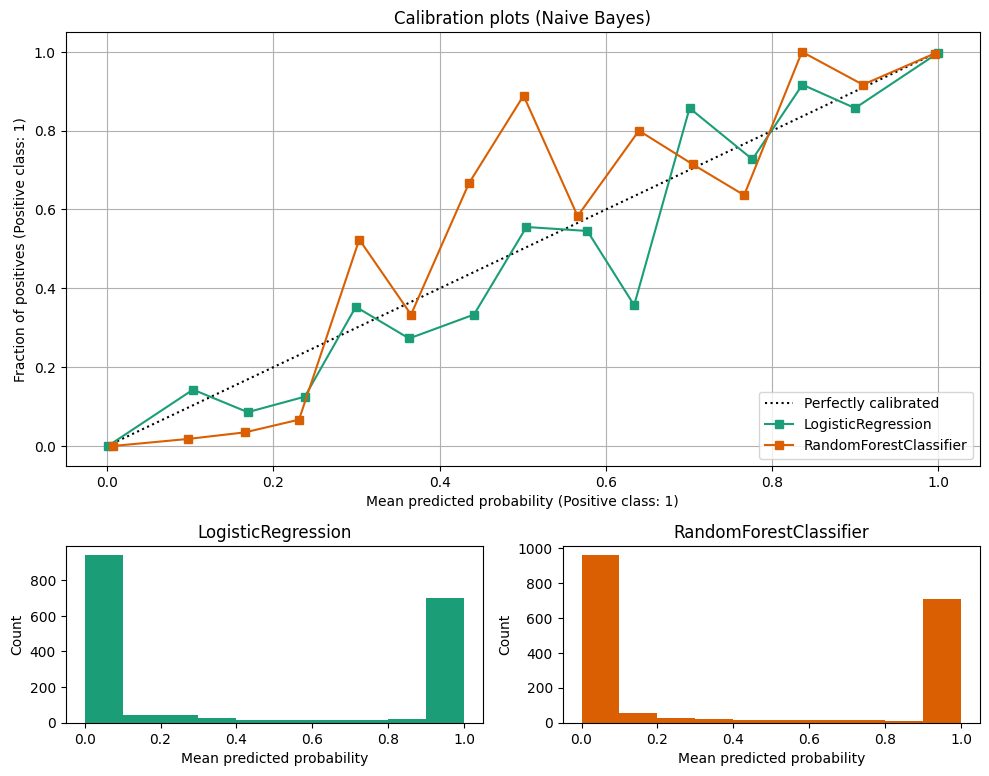

In [57]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (name, model) in enumerate(models.items()):
    clf = Pipeline(steps=[('preprocessing', preprocessing), ('model', model)])
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=15,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (name, _) in enumerate(models.items()):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()